In [1]:
try:
    from sklearnex import patch_sklearn, unpatch_sklearn
    patch_sklearn()
except:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 消費電力量と気温
消費電力量(comsumption)と気温(temperature)の関係は、２次関数的な非線形なので相関係数は低い値になっていました。<br>
しかし、Scikit-learnの線形回帰(LinearRegression)は２次多項式で非線形データに対する学習・予測が可能なので試してみます。<br>
つぎのコードは、消費電力量(comsumption)を正解データ、気温(temperature)を特徴量にして２次式の線形回帰モデルで学習し<br>
学習データの最低気温から最高気温まで0.1度刻みのテスト用気温データで予測した消費電力量をグラフ表示します。

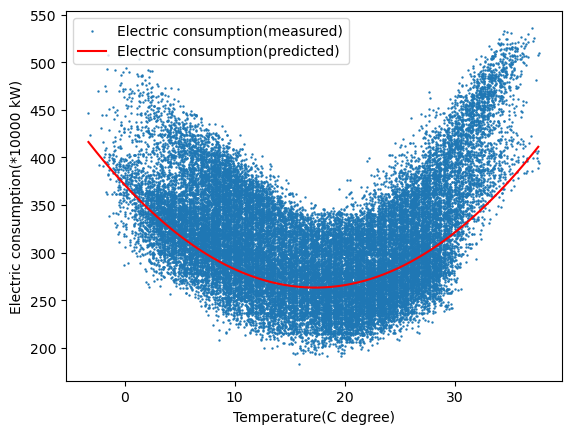

In [4]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'data/juyo_shikoku_{:d}.csv'.format(year),
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2017, 2018, 2019, 2020]
]
elec_data = pd.concat(ed)

# 複数年の気象データを読み込み
tp = [pd.read_csv(
    './data/takamatsu{:d}.csv'.format(year),
    skiprows=5,
    names=['DATETIME', 'temperature', 'temperature2', 'temperature3', 
           'sunhour1','sunhour2','sunhour3','sunhour4',
           'insolation','insolation2','insolation3',
           'humid','humid2','humid3'],
    parse_dates={'date_hour': ["DATETIME"]},
    index_col='date_hour')
    for year in [2017, 2018, 2019, 2020]
]

tmp = pd.concat(tp)

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
variable = ["temperature"]

takamatsu_wthr = elec_data.join(tmp[variable]).dropna()
takamatsu_elec = takamatsu_wthr.pop("consumption")

takamatsu_wthr["temp2"] = takamatsu_wthr["temperature"]**2

# 学習と性能の評価
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# 訓練データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2, random_state=0)


# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
x_train_normed = scaler.fit_transform(x_train)
# テストデータ標準化
x_test_normed = scaler.transform(x_test)

# 正解データ標準化
scaler2 = StandardScaler()
y_train_normed = scaler2.fit_transform(pd.DataFrame(y_train))
y_test_normed = scaler2.transform(pd.DataFrame(y_test))

model.fit(x_train_normed, y_train_normed.ravel())

px = np.arange(takamatsu_wthr['temperature'].min(),takamatsu_wthr['temperature'].max(),0.1)[:, np.newaxis]
df_px = pd.DataFrame(px, columns=['temperature'])
df_px["temp2"] = df_px['temperature']**2
px_normed = scaler.fit_transform(df_px)
py = model.predict(px_normed)

# グラフ表示
plt.xlabel('Temperature(C degree)')
plt.ylabel('Electric consumption(*10000 kW)')

plt.scatter(takamatsu_wthr['temperature'], takamatsu_elec,
            s=0.5, label='Electric consumption(measured)')
plt.plot(df_px["temperature"], scaler2.inverse_transform(pd.DataFrame(py)),
         color='red', label='Electric consumption(predicted)')

plt.legend(loc='upper left')
plt.show()


青色のドットが電力消費量と気温の実測値で赤線が予測値です。グラフでは実測値の中間あたりに予測値（赤線）が表示されています。<br>
このグラフを見ると、２次式を使った線形回帰モデルが使えそうです。

説明変数 = temperature
訓練スコア = 0.416388, 検証スコア = 0.410311


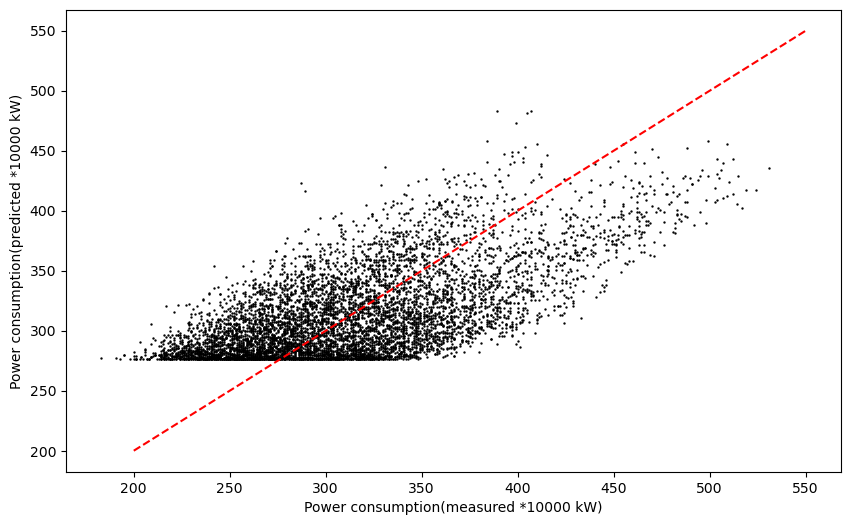

In [2]:
# coding: utf-8
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'data/juyo_shikoku_{:d}.csv'.format(year),
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2017, 2018, 2019, 2020]
]
elec_data = pd.concat(ed)

# 複数年の気象データを読み込み
tp = [pd.read_csv(
    './data/takamatsu{:d}.csv'.format(year),
    skiprows=5,
    names=['DATETIME', 'temperature', 'temperature2', 'temperature3', 
           'sunhour1','sunhour2','sunhour3','sunhour4',
           'insolation','insolation2','insolation3',
           'humid','humid2','humid3'],
    parse_dates={'date_hour': ["DATETIME"]},
    index_col='date_hour')
    for year in [2017, 2018, 2019, 2020]
]

tmp = pd.concat(tp)

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
variable = ["temperature"]

takamatsu_wthr = elec_data.join(tmp[variable]).dropna()
takamatsu_elec = takamatsu_wthr.pop("consumption")

# 多項式特徴量の追加
takamatsu_wthr["temp2"] = takamatsu_wthr["temperature"]**2

# 学習と性能の評価
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# 訓練データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2, random_state=0)


# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
x_train_normed = scaler.fit_transform(x_train)
# テストデータ標準化
x_test_normed = scaler.transform(x_test)

# 正解データ標準化
scaler2 = StandardScaler()
y_train_normed = scaler2.fit_transform(pd.DataFrame(y_train))
y_test_normed = scaler2.transform(pd.DataFrame(y_test))

model.fit(x_train_normed, y_train_normed.ravel())

score = "説明変数 = {}\n訓練スコア = {:f}, 検証スコア = {:f}".format(
          ", ".join(variable),
          model.score(x_train_normed, y_train_normed),
          model.score(x_test_normed, y_test_normed)
          )

print (score)

# -- 可視化 --
# 画像のサイズを設定する
plt.figure(figsize=(10, 6))

predicted = model.predict(x_test_normed)

plt.xlabel('Power consumption(measured *10000 kW)')
plt.ylabel('Power consumption(predicted *10000 kW)')
plt.scatter(scaler2.inverse_transform(y_test_normed), scaler2.inverse_transform(predicted.reshape(-1,1)), s=0.5, color="black")
plt.plot([200, 550], [200, 550], 'r--')

#plt.savefig("predict-power-consumption-graph.png")
plt.show()